# 基于自注意力机制的语言模型

先做一个简单地拼音映射为汉字的实验。

## 1. 数据处理
- 读取数据

In [1]:
with open("data/zh.tsv", 'r', encoding='utf-8') as fout:
    data = fout.readlines()[:100]

In [2]:
from tqdm import tqdm

inputs = []
labels = []
for i in tqdm(range(len(data))):
    key, pny, hanzi = data[i].split('\t')
    inputs.append(pny.split(' '))
    labels.append(hanzi.strip('\n').split(' '))

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 50129.13it/s]


In [3]:
print(inputs[:5])
print()
print(labels[:5])

[['lv4', 'shi4', 'yang2', 'chun1', 'yan1', 'jing3', 'da4', 'kuai4', 'wen2', 'zhang1', 'de', 'di3', 'se4', 'si4', 'yue4', 'de', 'lin2', 'luan2', 'geng4', 'shi4', 'lv4', 'de2', 'xian1', 'huo2', 'xiu4', 'mei4', 'shi1', 'yi4', 'ang4', 'ran2'], ['ta1', 'jin3', 'ping2', 'yao1', 'bu4', 'de', 'li4', 'liang4', 'zai4', 'yong3', 'dao4', 'shang4', 'xia4', 'fan1', 'teng2', 'yong3', 'dong4', 'she2', 'xing2', 'zhuang4', 'ru2', 'hai3', 'tun2', 'yi1', 'zhi2', 'yi3', 'yi1', 'tou2', 'de', 'you1', 'shi4', 'ling3', 'xian1'], ['pao4', 'yan3', 'da3', 'hao3', 'le', 'zha4', 'yao4', 'zen3', 'me', 'zhuang1', 'yue4', 'zheng4', 'cai2', 'yao3', 'le', 'yao3', 'ya2', 'shu1', 'de', 'tuo1', 'qu4', 'yi1', 'fu2', 'guang1', 'bang3', 'zi', 'chong1', 'jin4', 'le', 'shui3', 'cuan4', 'dong4'], ['ke3', 'shei2', 'zhi1', 'wen2', 'wan2', 'hou4', 'ta1', 'yi1', 'zhao4', 'jing4', 'zi', 'zhi3', 'jian4', 'zuo3', 'xia4', 'yan3', 'jian3', 'de', 'xian4', 'you4', 'cu1', 'you4', 'hei1', 'yu3', 'you4', 'ce4', 'ming2', 'xian3', 'bu4', 'dui4'

In [4]:
def get_vocab(data):
    vocab = ['<PAD>']
    for line in tqdm(data):
        for char in line:
            if char not in vocab:
                vocab.append(char)
    return vocab

pny2id = get_vocab(inputs)
han2id = get_vocab(labels)

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 5277.65it/s]


In [5]:
print(pny2id[:10])
print(han2id[:10])

['<PAD>', 'lv4', 'shi4', 'yang2', 'chun1', 'yan1', 'jing3', 'da4', 'kuai4', 'wen2']
['<PAD>', '绿', '是', '阳', '春', '烟', '景', '大', '块', '文']


In [6]:
input_num = [[pny2id.index(pny) for pny in line] for line in tqdm(inputs)]
label_num = [[han2id.index(han) for han in line] for line in tqdm(labels)]

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3855.73it/s]


In [7]:
import numpy as np
def get_batch(input_data, label_data, batch_size):
    batch_num = len(input_data) // batch_size
    for k in range(batch_num):
        begin = k * batch_size
        end = begin + batch_size
        input_batch = input_data[begin:end]
        label_batch = label_data[begin:end]
        max_len = max([len(line) for line in input_batch])
        input_batch = np.array([line + [0] * (max_len - len(line)) for line in input_batch])
        label_batch = np.array([line + [0] * (max_len - len(line)) for line in label_batch])
        yield input_batch, label_batch
        
        
batch = get_batch(input_num, label_num, 4)
input_batch, label_batch = next(batch)
print(input_batch)
print(label_batch)

[[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  11  16  17
   18   2   1  19  20  21  22  23  24  25  26  27   0   0   0]
 [ 28  29  30  31  32  11  33  34  35  36  37  38  39  40  41  36  42  43
   44  45  46  47  48  49  50  51  49  52  11  53   2  54  20]
 [ 55  56  57  58  59  60  61  62  63  64  15  65  66  67  59  67  68  69
   11  70  71  49  72  73  74  75  76  77  59  78  79  42   0]
 [ 80  81  82   9  83  84  28  49  85  86  75  87  88  89  39  56  90  11
   91  92  93  92  94  95  92  96  97  98  32  99 100   0   0]]
[[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  11  16  17
   18   2   1  19  20  21  22  23  24  25  26  27   0   0   0]
 [ 28  29  30  31  32  11  33  34  35  36  37  38  39  40  41  42  43  44
   45  46  47  48  49  50  51  52  50  53  11  54  55  56  57]
 [ 58  59  60  61  62  63  64  65  66  67  68  69  70  71  62  71  72  73
   74  75  76  77  78  79  80  81  82  83  62  84  85  86   0]
 [ 87  88  89  90  91  92  93  50  94  9

## 2.模型搭建
模型采用self-attention,模型结构如下：

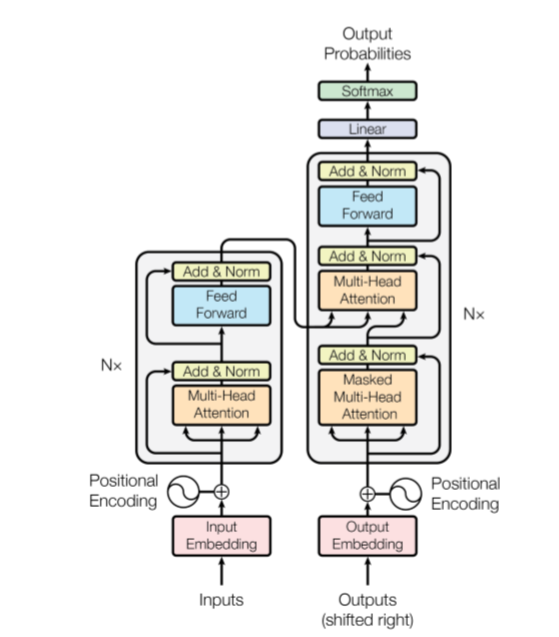

我们只需要搭建左侧编码器即可，不用搭建右侧解码器。

论文地址：https://arxiv.org/abs/1706.03762

模型代码搭建我们直接参考开源的代码：
https://github.com/Kyubyong/transformer/blob/master/modules.py

我们只需要注意每一快的输入输出数据形式怎样即可。

In [8]:
import tensorflow as tf

### 2.1 构造建模组件

下面代码实现了图片结构中的各个功能组件。
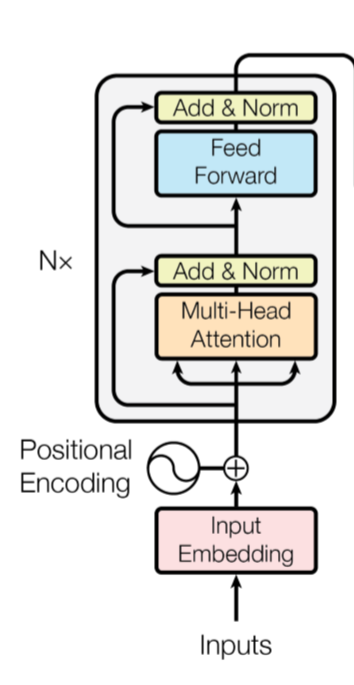

#### layer norm层

In [9]:
def normalize(inputs, 
              epsilon = 1e-8,
              scope="ln",
              reuse=None):
    '''Applies layer normalization.

    Args:
      inputs: A tensor with 2 or more dimensions, where the first dimension has
        `batch_size`.
      epsilon: A floating number. A very small number for preventing ZeroDivision Error.
      scope: Optional scope for `variable_scope`.
      reuse: Boolean, whether to reuse the weights of a previous layer
        by the same name.

    Returns:
      A tensor with the same shape and data dtype as `inputs`.
    '''
    with tf.variable_scope(scope, reuse=reuse):
        inputs_shape = inputs.get_shape()
        params_shape = inputs_shape[-1:]

        mean, variance = tf.nn.moments(inputs, [-1], keep_dims=True)
        beta= tf.Variable(tf.zeros(params_shape))
        gamma = tf.Variable(tf.ones(params_shape))
        normalized = (inputs - mean) / ( (variance + epsilon) ** (.5) )
        outputs = gamma * normalized + beta

    return outputs

#### embedding层

In [10]:
def embedding(inputs, 
              vocab_size, 
              num_units, 
              zero_pad=True, 
              scale=True,
              scope="embedding", 
              reuse=None):
    '''Embeds a given tensor.
    Args:
      inputs: A `Tensor` with type `int32` or `int64` containing the ids
         to be looked up in `lookup table`.
      vocab_size: An int. Vocabulary size.
      num_units: An int. Number of embedding hidden units.
      zero_pad: A boolean. If True, all the values of the fist row (id 0)
        should be constant zeros.
      scale: A boolean. If True. the outputs is multiplied by sqrt num_units.
      scope: Optional scope for `variable_scope`.
      reuse: Boolean, whether to reuse the weights of a previous layer
        by the same name.
    Returns:
      A `Tensor` with one more rank than inputs's. The last dimensionality
        should be `num_units`.

    For example,

    ```
    import tensorflow as tf

    inputs = tf.to_int32(tf.reshape(tf.range(2*3), (2, 3)))
    outputs = embedding(inputs, 6, 2, zero_pad=True)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        print sess.run(outputs)
    >>
    [[[ 0.          0.        ]
      [ 0.09754146  0.67385566]
      [ 0.37864095 -0.35689294]]
     [[-1.01329422 -1.09939694]
      [ 0.7521342   0.38203377]
      [-0.04973143 -0.06210355]]]
    ```

    ```
    import tensorflow as tf

    inputs = tf.to_int32(tf.reshape(tf.range(2*3), (2, 3)))
    outputs = embedding(inputs, 6, 2, zero_pad=False)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        print sess.run(outputs)
    >>
    [[[-0.19172323 -0.39159766]
      [-0.43212751 -0.66207761]
      [ 1.03452027 -0.26704335]]
     [[-0.11634696 -0.35983452]
      [ 0.50208133  0.53509563]
      [ 1.22204471 -0.96587461]]]
    ```    
    '''
    with tf.variable_scope(scope, reuse=reuse):
        lookup_table = tf.get_variable('lookup_table',
                                       dtype=tf.float32,
                                       shape=[vocab_size, num_units],
                                       initializer=tf.contrib.layers.xavier_initializer())
        if zero_pad:
            lookup_table = tf.concat((tf.zeros(shape=[1, num_units]),
                                      lookup_table[1:, :]), 0)
        outputs = tf.nn.embedding_lookup(lookup_table, inputs)

        if scale:
            outputs = outputs * (num_units ** 0.5) 

    return outputs

#### multihead层
该层实现了下面功能：
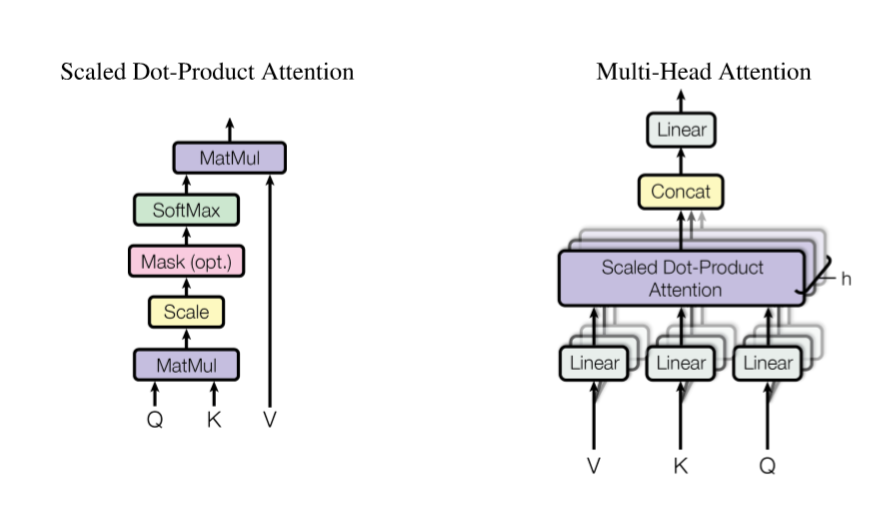

In [11]:
def multihead_attention(emb,
                        queries, 
                        keys, 
                        num_units=None, 
                        num_heads=8, 
                        dropout_rate=0,
                        is_training=True,
                        causality=False,
                        scope="multihead_attention", 
                        reuse=None):
    '''Applies multihead attention.
    
    Args:
      queries: A 3d tensor with shape of [N, T_q, C_q].
      keys: A 3d tensor with shape of [N, T_k, C_k].
      num_units: A scalar. Attention size.
      dropout_rate: A floating point number.
      is_training: Boolean. Controller of mechanism for dropout.
      causality: Boolean. If true, units that reference the future are masked. 
      num_heads: An int. Number of heads.
      scope: Optional scope for `variable_scope`.
      reuse: Boolean, whether to reuse the weights of a previous layer
        by the same name.
        
    Returns
      A 3d tensor with shape of (N, T_q, C)  
    '''
    with tf.variable_scope(scope, reuse=reuse):
        # Set the fall back option for num_units
        if num_units is None:
            num_units = queries.get_shape().as_list[-1]
        
        # Linear projections
        Q = tf.layers.dense(queries, num_units, activation=tf.nn.relu) # (N, T_q, C)
        K = tf.layers.dense(keys, num_units, activation=tf.nn.relu) # (N, T_k, C)
        V = tf.layers.dense(keys, num_units, activation=tf.nn.relu) # (N, T_k, C)
        
        # Split and concat
        Q_ = tf.concat(tf.split(Q, num_heads, axis=2), axis=0) # (h*N, T_q, C/h) 
        K_ = tf.concat(tf.split(K, num_heads, axis=2), axis=0) # (h*N, T_k, C/h) 
        V_ = tf.concat(tf.split(V, num_heads, axis=2), axis=0) # (h*N, T_k, C/h) 

        # Multiplication
        outputs = tf.matmul(Q_, tf.transpose(K_, [0, 2, 1])) # (h*N, T_q, T_k)
        
        # Scale
        outputs = outputs / (K_.get_shape().as_list()[-1] ** 0.5)
        
        # Key Masking
        key_masks = tf.sign(tf.abs(tf.reduce_sum(emb, axis=-1))) # (N, T_k)
        key_masks = tf.tile(key_masks, [num_heads, 1]) # (h*N, T_k)
        key_masks = tf.tile(tf.expand_dims(key_masks, 1), [1, tf.shape(queries)[1], 1]) # (h*N, T_q, T_k)
        
        paddings = tf.ones_like(outputs)*(-2**32+1)
        outputs = tf.where(tf.equal(key_masks, 0), paddings, outputs) # (h*N, T_q, T_k)
  
        # Causality = Future blinding
        if causality:
            diag_vals = tf.ones_like(outputs[0, :, :]) # (T_q, T_k)
            tril = tf.contrib.linalg.LinearOperatorTriL(diag_vals).to_dense() # (T_q, T_k)
            masks = tf.tile(tf.expand_dims(tril, 0), [tf.shape(outputs)[0], 1, 1]) # (h*N, T_q, T_k)
   
            paddings = tf.ones_like(masks)*(-2**32+1)
            outputs = tf.where(tf.equal(masks, 0), paddings, outputs) # (h*N, T_q, T_k)
  
        # Activation
        outputs = tf.nn.softmax(outputs) # (h*N, T_q, T_k)
         
        # Query Masking
        query_masks = tf.sign(tf.abs(tf.reduce_sum(emb, axis=-1))) # (N, T_q)
        query_masks = tf.tile(query_masks, [num_heads, 1]) # (h*N, T_q)
        query_masks = tf.tile(tf.expand_dims(query_masks, -1), [1, 1, tf.shape(keys)[1]]) # (h*N, T_q, T_k)
        outputs *= query_masks # broadcasting. (N, T_q, C)
          
        # Dropouts
        outputs = tf.layers.dropout(outputs, rate=dropout_rate, training=tf.convert_to_tensor(is_training))
               
        # Weighted sum
        outputs = tf.matmul(outputs, V_) # ( h*N, T_q, C/h)
        
        # Restore shape
        outputs = tf.concat(tf.split(outputs, num_heads, axis=0), axis=2 ) # (N, T_q, C)
              
        # Residual connection
        outputs += queries
              
        # Normalize
        outputs = normalize(outputs) # (N, T_q, C)
 
    return outputs

#### feedforward

两层全连接，用卷积模拟加速运算，也可以使用dense层。

In [12]:
def feedforward(inputs, 
                num_units=[2048, 512],
                scope="multihead_attention", 
                reuse=None):
    '''Point-wise feed forward net.
    
    Args:
      inputs: A 3d tensor with shape of [N, T, C].
      num_units: A list of two integers.
      scope: Optional scope for `variable_scope`.
      reuse: Boolean, whether to reuse the weights of a previous layer
        by the same name.
        
    Returns:
      A 3d tensor with the same shape and dtype as inputs
    '''
    with tf.variable_scope(scope, reuse=reuse):
        # Inner layer
        params = {"inputs": inputs, "filters": num_units[0], "kernel_size": 1,
                  "activation": tf.nn.relu, "use_bias": True}
        outputs = tf.layers.conv1d(**params)
        
        # Readout layer
        params = {"inputs": outputs, "filters": num_units[1], "kernel_size": 1,
                  "activation": None, "use_bias": True}
        outputs = tf.layers.conv1d(**params)
        
        # Residual connection
        outputs += inputs
        
        # Normalize
        outputs = normalize(outputs)
    
    return outputs

#### label_smoothing.
对于训练有好处，将0变为接近零的小数，1变为接近1的数，原文：

During training, we employed label smoothing of value ls = 0.1 [36]. This hurts perplexity, as the model learns to be more unsure, but improves accuracy and BLEU score.

In [13]:
def label_smoothing(inputs, epsilon=0.1):
    '''Applies label smoothing. See https://arxiv.org/abs/1512.00567.
    
    Args:
      inputs: A 3d tensor with shape of [N, T, V], where V is the number of vocabulary.
      epsilon: Smoothing rate.
    
    For example,
    
    ```
    import tensorflow as tf
    inputs = tf.convert_to_tensor([[[0, 0, 1], 
       [0, 1, 0],
       [1, 0, 0]],
      [[1, 0, 0],
       [1, 0, 0],
       [0, 1, 0]]], tf.float32)
       
    outputs = label_smoothing(inputs)
    
    with tf.Session() as sess:
        print(sess.run([outputs]))
    
    >>
    [array([[[ 0.03333334,  0.03333334,  0.93333334],
        [ 0.03333334,  0.93333334,  0.03333334],
        [ 0.93333334,  0.03333334,  0.03333334]],
       [[ 0.93333334,  0.03333334,  0.03333334],
        [ 0.93333334,  0.03333334,  0.03333334],
        [ 0.03333334,  0.93333334,  0.03333334]]], dtype=float32)]   
    ```    
    '''
    K = inputs.get_shape().as_list()[-1] # number of channels
    return ((1-epsilon) * inputs) + (epsilon / K)

### 2.2 搭建模型
模型实现下图结构：
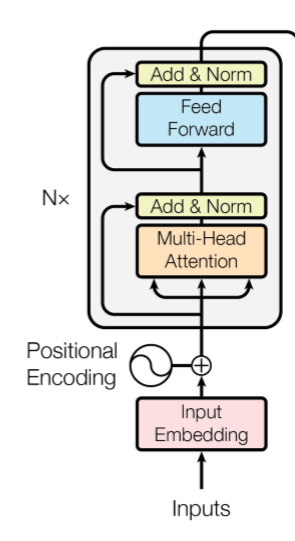

In [14]:
class Graph():
    def __init__(self, is_training=True):
        tf.reset_default_graph()
        self.is_training = arg.is_training
        self.hidden_units = arg.hidden_units
        self.input_vocab_size = arg.input_vocab_size
        self.label_vocab_size = arg.label_vocab_size
        self.num_heads = arg.num_heads
        self.num_blocks = arg.num_blocks
        self.max_length = arg.max_length
        self.lr = arg.lr
        self.dropout_rate = arg.dropout_rate
        
        # input
        self.x = tf.placeholder(tf.int32, shape=(None, None))
        self.y = tf.placeholder(tf.int32, shape=(None, None))
        # embedding
        self.emb = embedding(self.x, vocab_size=self.input_vocab_size, num_units=self.hidden_units, scale=True, scope="enc_embed")
        self.enc = self.emb + embedding(tf.tile(tf.expand_dims(tf.range(tf.shape(self.x)[1]), 0), [tf.shape(self.x)[0], 1]),
                                      vocab_size=self.max_length,num_units=self.hidden_units, zero_pad=False, scale=False,scope="enc_pe")
        ## Dropout
        self.enc = tf.layers.dropout(self.enc, 
                                    rate=self.dropout_rate, 
                                    training=tf.convert_to_tensor(self.is_training))
                
        ## Blocks
        for i in range(self.num_blocks):
            with tf.variable_scope("num_blocks_{}".format(i)):
                ### Multihead Attention
                self.enc = multihead_attention(emb = self.emb,
                                               queries=self.enc, 
                                                keys=self.enc, 
                                                num_units=self.hidden_units, 
                                                num_heads=self.num_heads, 
                                                dropout_rate=self.dropout_rate,
                                                is_training=self.is_training,
                                                causality=False)
                        
        ### Feed Forward
        self.outputs = feedforward(self.enc, num_units=[4*self.hidden_units, self.hidden_units])
            
                
        # Final linear projection
        self.logits = tf.layers.dense(self.outputs, self.label_vocab_size)
        self.preds = tf.to_int32(tf.argmax(self.logits, axis=-1))
        self.istarget = tf.to_float(tf.not_equal(self.y, 0))
        self.acc = tf.reduce_sum(tf.to_float(tf.equal(self.preds, self.y))*self.istarget)/ (tf.reduce_sum(self.istarget))
        tf.summary.scalar('acc', self.acc)
                
        if is_training:  
            # Loss
            self.y_smoothed = label_smoothing(tf.one_hot(self.y, depth=self.label_vocab_size))
            self.loss = tf.nn.softmax_cross_entropy_with_logits(logits=self.logits, labels=self.y_smoothed)
            self.mean_loss = tf.reduce_sum(self.loss*self.istarget) / (tf.reduce_sum(self.istarget))
               
            # Training Scheme
            self.global_step = tf.Variable(0, name='global_step', trainable=False)
            self.optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.9, beta2=0.98, epsilon=1e-8)
            self.train_op = self.optimizer.minimize(self.mean_loss, global_step=self.global_step)
                   
            # Summary 
            tf.summary.scalar('mean_loss', self.mean_loss)
            self.merged = tf.summary.merge_all()

## 3. 训练模型
### 3.1 参数设定

In [15]:
def create_hparams():
    params = tf.contrib.training.HParams(
        num_heads = 8,
        num_blocks = 6,
        # vocab
        input_vocab_size = 50,
        label_vocab_size = 50,
        # embedding size
        max_length = 100,
        hidden_units = 512,
        dropout_rate = 0.2,
        lr = 0.0003,
        is_training = True)
    return params

        
arg = create_hparams()
arg.input_vocab_size = len(pny2id)
arg.label_vocab_size = len(han2id)

### 3.2 模型训练

In [16]:
import os

epochs = 25
batch_size = 4

g = Graph(arg)

saver =tf.train.Saver()
with tf.Session() as sess:
    merged = tf.summary.merge_all()
    sess.run(tf.global_variables_initializer())
    if os.path.exists('logs/model.meta'):
        saver.restore(sess, 'logs/model')
    writer = tf.summary.FileWriter('tensorboard/lm', tf.get_default_graph())
    for k in range(epochs):
        total_loss = 0
        batch_num = len(input_num) // batch_size
        batch = get_batch(input_num, label_num, batch_size)
        for i in range(batch_num):
            input_batch, label_batch = next(batch)
            feed = {g.x: input_batch, g.y: label_batch}
            cost,_ = sess.run([g.mean_loss,g.train_op], feed_dict=feed)
            total_loss += cost
            if (k * batch_num + i) % 10 == 0:
                rs=sess.run(merged, feed_dict=feed)
                writer.add_summary(rs, k * batch_num + i)
        if (k+1) % 5 == 0:
            print('epochs', k+1, ': average loss = ', total_loss/batch_num)
    saver.save(sess, 'logs/model')
    writer.close()

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

epochs 5 : average loss =  1.6399681091308593
epochs 10 : average loss =  1.1646613264083863
epochs 15 : average loss =  1.157580156326294
epochs 20 : average loss =  1.1407248640060426
epochs 25 : average loss =  1.1298853492736816


### 3.3 模型推断

In [18]:
arg.is_training = False

g = Graph(arg)

saver =tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, 'logs/model')
    while True:
        line = input('输入测试拼音: ')
        if line == 'exit': break
        line = line.strip('\n').split(' ')
        x = np.array([pny2id.index(pny) for pny in line])
        x = x.reshape(1, -1)
        preds = sess.run(g.preds, {g.x: x})
        got = ''.join(han2id[idx] for idx in preds[0])
        print(got)

INFO:tensorflow:Restoring parameters from logs/model
输入测试拼音: shen1 ye4 shi2 er4 dian3 zhong1 ta1 zhan4 zai4 shao4 wei4 shang4 huan2 shi4 zhou1 wei2 yin1 sen1 ke3 bu4 yue4 xiang3 yue4 hai4 pa4 bao4 qiang1 ku1 zhe pao3 hui2 ying2 fang2
深夜十二点钟他站在哨位上环视周围阴森可怖越想越害怕抱枪哭着跑回营房
输入测试拼音: wu3 yue4 er4 shi2 jiu3 ri4 ye4 wan3 ao4 da4 li4 ya4 shou3 dou1 kan1 pei2 la1 de huang2 jia1 ju4 yuan4 re4 lie4 er2 chong1 man3 zhe zhen1 qing2
五月二十九日夜晚澳大利亚首都堪培拉的皇家剧院热烈而充满着真情
输入测试拼音: tai4 hu2 dong1 an4 yi1 dai4 de yun2 tuan2 you2 dan4 dao4 nong2 zai4 you2 nong2 dao4 dan4 er2 shang4 hai3 shi4 qu1 shang4 kong1 de yun2 yue4 lai2 yue4 shao3 yue4 lai2 yue4 xi1
太湖东岸一带的云团由淡到浓再由浓到淡而上海市区上空的云越来越少越来越稀
输入测试拼音: exit
